In [1]:

%load_ext autoreload
%autoreload 2

import geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import torch
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from seisnet.dataloaders import Normalize

/Users/josesomojola/project/.venv/lib/python3.9/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/josesomojola/project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### SeisBench Refresher

In [2]:
data = sbd.DummyDataset(sampling_rate=100)
wvfms = data.get_waveforms()

2025-06-06 10:08:21,373 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


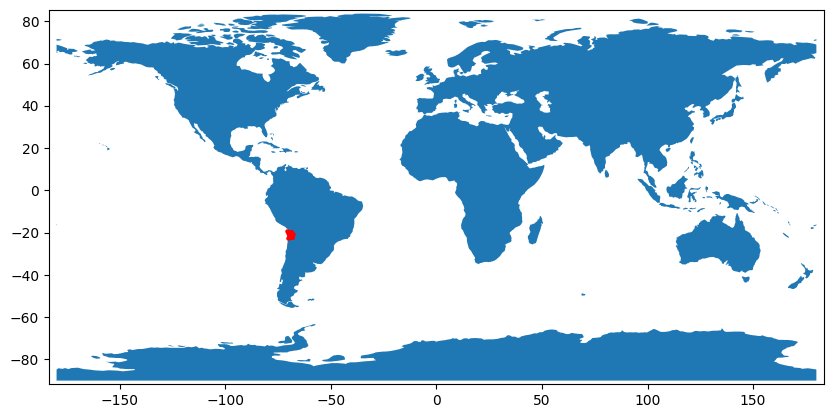

In [3]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
fig,ax = plt.subplots(figsize=(10,6))
world.plot(ax=ax,aspect="auto")
ax.scatter(data.metadata.source_longitude_deg,data.metadata.source_latitude_deg,s=5,c="r")
ax.margins(x=0.01,y=0.01)
plt.show()

### Load the seisbench phasenet model

In [4]:
phn_mdl = sbm.PhaseNet.from_pretrained("original")

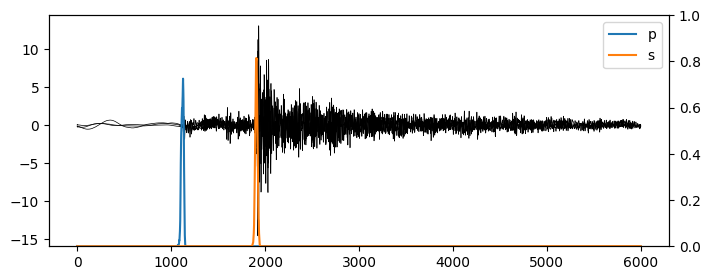

In [8]:
n = 3
wvfm = {"X": wvfms[n], "y": np.nan}
nwvfm = Normalize("mnstd")(wvfm)
nvfmt = torch.Tensor(nwvfm["X"], device=phn_mdl.device).unsqueeze(0)

phn_mdl.eval()
with torch.no_grad():
    pred = phn_mdl(nvfmt)
    pred = pred[0].cpu().numpy()

fig,ax = plt.subplots(figsize=(8,3))
ax.plot(nwvfm["X"].T, c="k", lw=0.5)
ax = ax.twinx()
ax.plot(pred[1,:], label="p")
ax.plot(pred[2,:], label="s")
ax.set_ylim(0,1)
plt.legend()

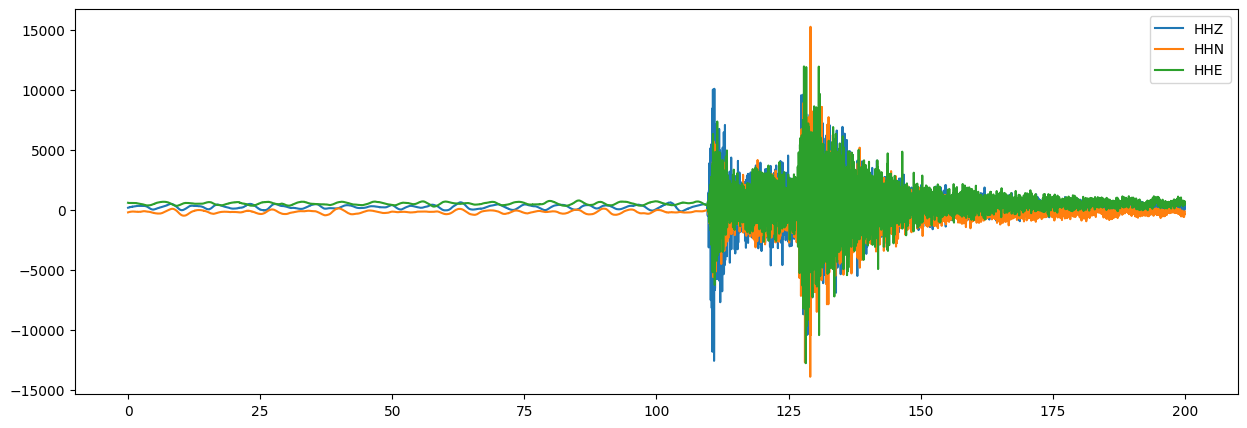

In [9]:
client = Client("GFZ")

t = UTCDateTime("2007/01/02 05:48:50")
stream = client.get_waveforms(network="CX", station="PB01", location="*", channel="HH?", starttime=t-100, endtime=t+100)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

### Perform a prediction

(<matplotlib.legend.Legend at 0x157977580>, (0.0, 1.0))

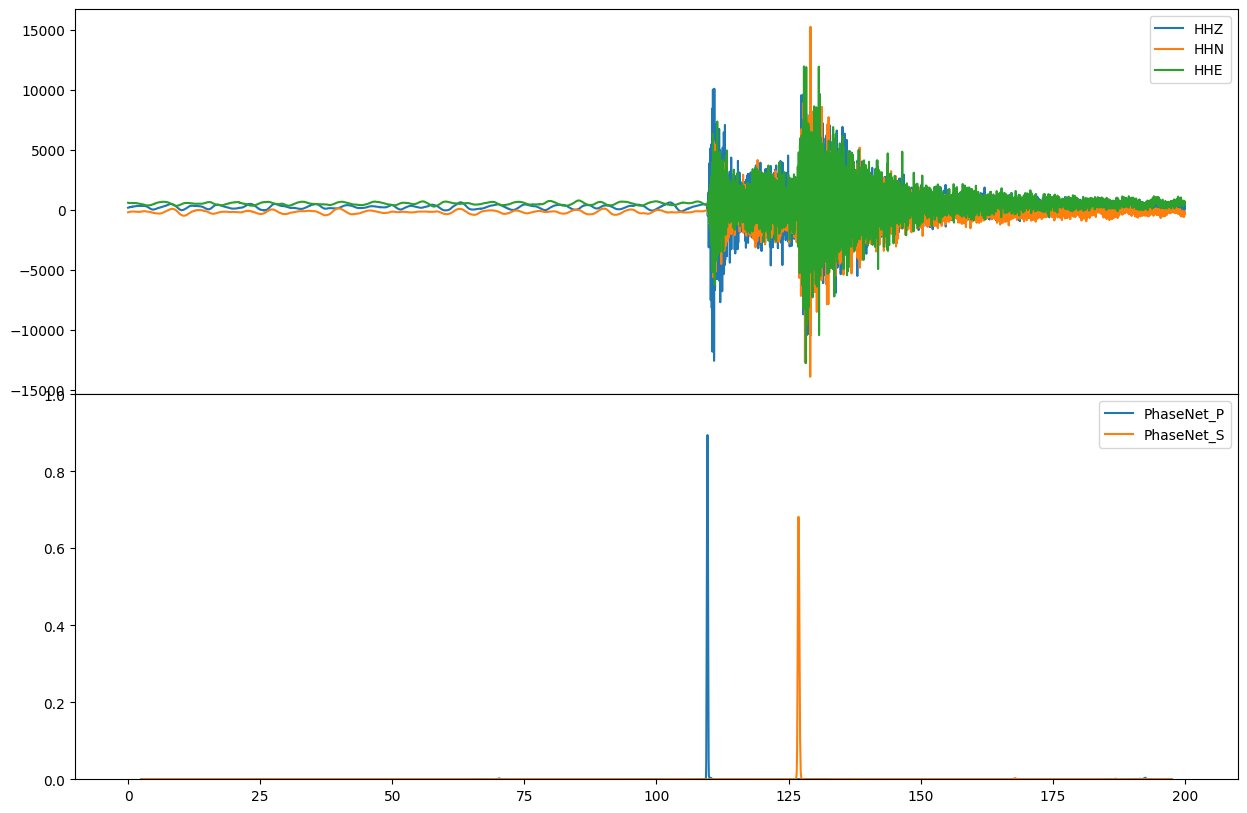

In [10]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

annotations = phn_mdl.annotate(stream)
offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend(),axs[0].margins(x=0.01)
axs[1].legend(),axs[1].set_ylim(0,1)